In [ ]:
"""
Implements the gridworld MDP.

Matthew Alger, 2015
matthew.alger@anu.edu.au
"""

import numpy as np
import numpy.random as rn

class Gridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount,horizon):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount
        self.horizon = horizon

        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])
        self.reward_v = np.array([[self.reward(s) for s in range(self.n_states)] for a in range(self.n_actions)]).T
    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)

        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions

    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """

        if state_int == self.n_states - 1:
            return 1
        return 0



import math
import numpy as np
import scipy.special

inf  = float("inf")

def soft_bellman_operation(env, reward):
    
    # Input:    env    :  environment object
    #           reward :  SxA dimensional vector 
    #           horizon:  finite horizon
        
    discount = env.discount
    horizon = env.horizon
    
    if horizon is None or math.isinf(horizon):
        raise ValueError("Only finite horizon environments are supported")
    
    n_states  = env.n_states
    n_actions = env.n_actions
    
#     T = env.transition_matrix
    
    V = np.zeros(shape = (horizon, n_states))
    Q = np.zeros(shape = (horizon, n_states,n_actions))
        
    broad_R = reward

    # Base case: final timestep
    # final Q(s,a) is just reward
    Q[horizon - 1, :, :] = broad_R
    # V(s) is always normalising constant
    V[horizon - 1, :] = scipy.special.logsumexp(Q[horizon - 1, :, :], axis=1)

    # Recursive case
    for t in reversed(range(horizon - 1)):
#         next_values_s_a = T @ V[t + 1, :]
#         next_values_s_a = next_values_s_a.reshape(n_states,n_actions)
        for a in range(n_actions):
            Ta = env.transition_probability[:,a,:]
            next_values_s_a = Ta@V[t + 1, :]
            Q[t, :, a] = broad_R[:,a] + discount * next_values_s_a
            
        V[t, :] = scipy.special.logsumexp(Q[t, :, :], axis=1)

    pi = np.exp(Q - V[:, :, None])

    return V, Q, pi


def create_Pi(pi):
    horizon, n_states, n_actions = pi.shape
    
    Pi = np.zeros(((horizon - 1)*n_states*n_actions,1))
    
    for t in range(horizon-1):
        curr_pi = pi[t].flatten('F')[:,None]
#         print(curr_pi.shape)
        next_pi = pi[t+1].flatten('F')[:,None]
        Pi[t*n_states*n_actions:(t+1)*n_states*n_actions] = np.log(curr_pi) - np.log(next_pi)
    return Pi

In [ ]:
grid_size = 5
wind = 0.1
discount = 0.99
horizon = 5

gw = Gridworld(grid_size,wind,discount,horizon)

reward = gw.reward_v
reward[-1][-1] = 1
V,Q,pi = soft_bellman_operation(gw,gw.reward_v)


# Construct Psi and Pi
I = np.eye(gw.n_states)
E = I
P = gw.transition_probability[:,0,:]

for a in range(1, gw.n_actions):
    E = np.vstack((E,I))
    P = np.vstack((P, gw.transition_probability[:,a,:]))
    
gamma = gw.discount
psi_rows = (horizon - 1)*gw.n_states*gw.n_actions
psi_cols = horizon*gw.n_states

Pi = create_Pi(pi)

Psi = np.zeros((psi_rows, psi_cols))

for i in range(horizon-1):
    Psi[i*gw.n_states*gw.n_actions:(i+1)*gw.n_states*gw.n_actions, i*gw.n_states:(i+1)*gw.n_states] = E
    Psi[i*gw.n_states*gw.n_actions:(i+1)*gw.n_states*gw.n_actions, (i+1)*gw.n_states:(i+2)*gw.n_states] = -discount*P
    
print("The rank of P is  : ", np.linalg.matrix_rank(P))
print("The rank of Psi is: ", np.linalg.matrix_rank(Psi))

# find the  solution
v = np.linalg.pinv(Psi) @ Pi
print("The last solution is: ", v[-grid_size**2:])
# print("The kernel of Psi is: ", scipy.linalg.null_space(Psi))

In [ ]:
class BlockingGridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount,horizon,start_state, feature_dim, p1, p2):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.wind_buffer = wind
        
        self.discount = discount
        self.horizon = horizon
        self.feature_dim = feature_dim
        self.p1 = p1
        self.p2 = p2
        
        self.blocked_states = [6,7,8,9]
        
        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])
        
        
        
        self.normalize_transition_matrices()
        
        self.make_state_determinstic(1)
        self.make_state_determinstic(2)
        self.make_state_determinstic(3)
        self.make_state_determinstic(4)
        
        
        
        self.start_state = start_state
#         self.make_state_determinstic(12)
        self.reward_v = np.array([[self.reward(s) for s in range(self.n_states)] for a in range(self.n_actions)]).T
    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)
            
        
        # is this state blocked in the MDP?
        left_column = (i == 1) or (i == 2) or (i == 3) or (i == 4)
        lc = [1,2,3,4]
        
        # disallow self transitions for the left column
        if i == k and left_column:
            return 0.0
        
        #disallow transition from the leftmost column to the one next to it
        if k in self.blocked_states and left_column:
            return 0.0
        
        #disallow transition from the 2nd column to the left most column 
        if k in lc and i in self.blocked_states:
            return 0.0
        
        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions
            
    def normalize_transition_matrices(self):
        for a in range(self.n_actions):
            P = self.transition_probability[:,a,:]
            sum_P = P.sum(axis = 1)
            normalized_P = P/sum_P[:,None]
            self.transition_probability[:,a,:] = normalized_P
            
    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """

        if state_int == self.n_states - 1:
            return 1
        return 0
    
    def make_state_determinstic(self, s):
        
        for s_prime in range(self.n_states):
            for a in range(self.n_actions):
                self.transition_probability[s,a,s_prime] = 0.0
                
        for a in range(self.n_actions):
            self.transition_probability[s,a,s-1] = 1.0
         
            
    def generate_trajectories(self):
        # Memoization dictionary to store already computed results
        horizon = self.horizon
        memo_dict = {}

        def generate_recursive(current_time, current_state):
            # Check if the result is already computed
            if (current_time, current_state) in memo_dict:
                return memo_dict[(current_time, current_state)]

            # Base case: when we reach the horizon, return an empty trajectory
            if current_time == horizon:
                return [[]]

            trajectories = [] 

            # Recursive case: try all actions and next states
            for action in range(self.n_actions):
                next_state_probs = self.transition_probability[current_state,action,:] if current_state is not None else self.start_distribution

                for next_state in range(self.n_states):
                    # Recursive call
                    if next_state_probs[next_state] != 0:
                        next_trajectories = generate_recursive(current_time + 1, next_state)

                        # Extend the current trajectory with the current action and next state
                        if current_state == None:

                            trajectories.extend([(next_state, action )] + traj for traj in next_trajectories)
                        else:
                            trajectories.extend([(current_state, action, next_state)] + traj for traj in next_trajectories)

            # Memoize the result before returning
            memo_dict[(current_time, current_state)] = trajectories
            
            print("Length is:", len(trajectories))
            return trajectories

        # Start the recursion with time = 0 and no initial state
        # For a unique starting state
        return generate_recursive(0, self.start_state)
    
    def get_trajectory_matrix(self):
        
        trajs = self.generate_trajectories()
        
        M = np.zeros((len(trajs), self.n_states*self.n_actions ))
        
        
        for i in range(len(trajs)):
            for t,time_step in enumerate(trajs[i]):
                
                s = time_step[0]
                a = time_step[1]
                
                pos_ = a*self.n_states + s
                
                M[i][pos_] += self.discount**t
                
        return M
    
   
    def manhatten_distance(self, i,k):
        
        xi, yi = self.int_to_point(i)
        xk, yk = self.int_to_point(k)
        
        return np.abs(xi-xk) + np.abs(yi- yk)
    
    def feature_vector(self,s,a):
        
        f = np.zeros((self.feature_dim,1))
        
        f[0] = self.manhatten_distance(s, self.p1)
        
        f[1] = self.manhatten_distance(s, self.p2)
        
        
        
        xs, ys  = self.int_to_point(s)
        xa, ya = self.actions[a]
        
        des_ = (xs+xa,ys+ya)
        des_s = self.point_to_int(des_)
        
        if self.manhatten_distance(des_s , self.p1) <= f[0]:
            f[0] += 1
        else: 
            f[0] -= 1
        
        if self.manhatten_distance(des_s , self.p2) <= f[1]:
            f[1] += 1
        else: 
            f[1] -= 1
        
        return f
    
    def F_matrix(self):
        F = np.zeros((self.n_states*self.n_states, 2))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                F[s + a*self.n_states] = self.feature_vector(s,a).T
                
        return F
    

In [ ]:
np.zeros((2,1))

In [ ]:
# smaller MDP world

class BlockingGridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount,horizon,start_state):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.wind_buffer = wind
        
        self.discount = discount
        self.horizon = horizon
        self.blocked_states = [5,6,7]
        
        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])
        
        
        
        self.normalize_transition_matrices()
        
        self.make_state_determinstic(1)
        self.make_state_determinstic(2)
        self.make_state_determinstic(3)
#         self.make_state_determinstic(4)
        
        
        
        self.start_state = start_state
#         self.make_state_determinstic(12)
        self.reward_v = np.array([[self.reward(s) for s in range(self.n_states)] for a in range(self.n_actions)]).T
    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)
            
        
        # is this state blocked in the MDP?
        left_column = (i == 1) or (i == 2) or (i == 3)
        lc = [1,2,3]
        
        # disallow self transitions for the left column
        if i == k and left_column:
            return 0.0
        
        #disallow transition from the leftmost column to the one next to it
        if k in self.blocked_states and left_column:
            return 0.0
        
        #disallow transition from the 2nd column to the left most column 
        if k in lc and i in self.blocked_states:
            return 0.0
        
        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions
            
    def normalize_transition_matrices(self):
        for a in range(self.n_actions):
            P = self.transition_probability[:,a,:]
            sum_P = P.sum(axis = 1)
            normalized_P = P/sum_P[:,None]
            self.transition_probability[:,a,:] = normalized_P
            
    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """

        if state_int == self.n_states - 1:
            return 1
        return 0
    
    def make_state_determinstic(self, s):
        
        for s_prime in range(self.n_states):
            for a in range(self.n_actions):
                self.transition_probability[s,a,s_prime] = 0.0
                
        for a in range(self.n_actions):
            self.transition_probability[s,a,s-1] = 1.0
         
            
    def generate_trajectories(self):
        # Memoization dictionary to store already computed results
        horizon = self.horizon
        memo_dict = {}

        def generate_recursive(current_time, current_state):
            # Check if the result is already computed
            if (current_time, current_state) in memo_dict:
                return memo_dict[(current_time, current_state)]

            # Base case: when we reach the horizon, return an empty trajectory
            if current_time == horizon:
#                 print("Current time is: ", current_time)
                return [[]]

            trajectories = [] 

            # Recursive case: try all actions and next states
            for action in range(self.n_actions):
                next_state_probs = self.transition_probability[current_state,action,:] if current_state is not None else self.start_distribution

                for next_state in range(self.n_states):
                    # Recursive call
                    if next_state_probs[next_state] != 0:
                        next_trajectories = generate_recursive(current_time + 1, next_state)

                        # Extend the current trajectory with the current action and next state
                        if current_state == None:

                            trajectories.extend([(next_state, action )] + traj for traj in next_trajectories)
                        else:
                            trajectories.extend([(current_state, action, next_state)] + traj for traj in next_trajectories)

            # Memoize the result before returning
            memo_dict[(current_time, current_state)] = trajectories
            
            print("Length is:", len(trajectories))
            return trajectories

        # Start the recursion with time = 0 and no initial state
        # For a unique starting state
        return generate_recursive(0, self.start_state)
    
    def get_trajectory_matrix(self):
        
        trajs = self.generate_trajectories()
        
        M = np.zeros((len(trajs), self.n_states*self.n_actions ))
        
        
        for i in range(len(trajs)):
            for t,time_step in enumerate(trajs[i]):
                
                s = time_step[0]
                a = time_step[1]
                
                pos_ = a*self.n_states + s
                
                M[i][pos_] += self.discount**t
                
        return M
            
        
        

In [ ]:
# less stochastic version

# smaller MDP world

class BlockingGridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount,horizon,start_state):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.wind_buffer = wind
        
        self.discount = discount
        self.horizon = horizon
        self.blocked_states = [5,6,7]
        
        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])
        
        
        self.reduce_stochasticity()
        self.normalize_transition_matrices()
        
        self.make_state_determinstic(1)
        self.make_state_determinstic(2)
        self.make_state_determinstic(3)
#         self.make_state_determinstic(4)
        
        
        
        self.start_state = start_state
#         self.make_state_determinstic(12)
        self.reward_v = np.array([[self.reward(s) for s in range(self.n_states)] for a in range(self.n_actions)]).T
    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)
            
        
        # is this state blocked in the MDP?
        left_column = (i == 1) or (i == 2) or (i == 3)
        lc = [1,2,3]
        
        # disallow self transitions for the left column
        if i == k and left_column:
            return 0.0
        
        #disallow transition from the leftmost column to the one next to it
        if k in self.blocked_states and left_column:
            return 0.0
        
        #disallow transition from the 2nd column to the left most column 
        if k in lc and i in self.blocked_states:
            return 0.0
        
        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) == (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions
            
    def normalize_transition_matrices(self):
        for a in range(self.n_actions):
            P = self.transition_probability[:,a,:]
            sum_P = P.sum(axis = 1)
            normalized_P = P/sum_P[:,None]
            self.transition_probability[:,a,:] = normalized_P
            
    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """

        if state_int == self.n_states - 1:
            return 1
        return 0
    
    def make_state_determinstic(self, s):
        
        for s_prime in range(self.n_states):
            for a in range(self.n_actions):
                self.transition_probability[s,a,s_prime] = 0.0
                
        for a in range(self.n_actions):
            self.transition_probability[s,a,s-1] = 1.0
         
            
    def generate_trajectories(self):
        # Memoization dictionary to store already computed results
        horizon = self.horizon
        memo_dict = {}

        def generate_recursive(current_time, current_state):
            # Check if the result is already computed
            if (current_time, current_state) in memo_dict:
                return memo_dict[(current_time, current_state)]

            # Base case: when we reach the horizon, return an empty trajectory
            if current_time == horizon:
#                 print("Current time is: ", current_time)
                return [[]]

            trajectories = [] 

            # Recursive case: try all actions and next states
            for action in range(self.n_actions):
                next_state_probs = self.transition_probability[current_state,action,:] if current_state is not None else self.start_distribution

                for next_state in range(self.n_states):
                    # Recursive call
                    if next_state_probs[next_state] != 0:
                        next_trajectories = generate_recursive(current_time + 1, next_state)

                        # Extend the current trajectory with the current action and next state
                        if current_state == None:

                            trajectories.extend([(next_state, action )] + traj for traj in next_trajectories)
                        else:
                            trajectories.extend([(current_state, action, next_state)] + traj for traj in next_trajectories)

            # Memoize the result before returning
            memo_dict[(current_time, current_state)] = trajectories
            
            print("Length is:", len(trajectories))
            return trajectories

        # Start the recursion with time = 0 and no initial state
        # For a unique starting state
        return generate_recursive(0, self.start_state)
    
    
    def reduce_stochasticity(self):
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                min_index = np.argsort(self.transition_probability[s][a])[-2]
                max_index = np.argsort(self.transition_probability[s][a])[-1]
                
                min_ = self.transition_probability[s][a][min_index]
                max_ = self.transition_probability[s][a][max_index]
                
                self.transition_probability[s][a] = 0
                
                if np.random.rand() > 0.8:
                    self.transition_probability[s][a][min_index] = min_
                    
                self.transition_probability[s][a][max_index] = max_
        
    def get_trajectory_matrix(self):
        
        trajs = self.generate_trajectories()
        
        M = np.zeros((len(trajs), self.n_states*self.n_actions ))
        
        
        for i in range(len(trajs)):
            for t,time_step in enumerate(trajs[i]):
                
                s = time_step[0]
                a = time_step[1]
                
                pos_ = a*self.n_states + s
                
                M[i][pos_] += self.discount**t
                
        return M
            
        
        

In [ ]:
grid_size = 4
wind = 0.1
discount = 0.9
horizon = 10
start_state = 15


gw = BlockingGridworld(grid_size,wind,discount,horizon,start_state)

reward = gw.reward_v
reward[-1][-1] = 1
V,Q,pi = soft_bellman_operation(gw,gw.reward_v)


# Construct Psi and Pi
I = np.eye(gw.n_states)
E = I
P = gw.transition_probability[:,0,:]

for a in range(1, gw.n_actions):
    E = np.vstack((E,I))
    P = np.vstack((P, gw.transition_probability[:,a,:]))
    
gamma = gw.discount
psi_rows = (horizon - 1)*gw.n_states*gw.n_actions
psi_cols = horizon*gw.n_states

Pi = create_Pi(pi)

Psi = np.zeros((psi_rows, psi_cols))

for i in range(horizon-1):
    Psi[i*gw.n_states*gw.n_actions:(i+1)*gw.n_states*gw.n_actions, i*gw.n_states:(i+1)*gw.n_states] = E
    Psi[i*gw.n_states*gw.n_actions:(i+1)*gw.n_states*gw.n_actions, (i+1)*gw.n_states:(i+2)*gw.n_states] = -discount*P

# vector that is in kernel of Psi, sanity check for Psi
v = np.ones((horizon*grid_size**2,1))
for i in range(horizon):
    v[i*grid_size**2:(i+1)*grid_size**2] = discount**(horizon-1 -i)
    
assert np.linalg.norm(Psi@v) <= 1e-5

print("The rank of P is  : ", np.linalg.matrix_rank(P))
print("The rank of Psi is: ", np.linalg.matrix_rank(Psi))

# find the  solution
v = np.linalg.pinv(Psi) @ Pi
print("The solution of mu (V_{T-1}) is: ", v[-grid_size**2:])
print("The dim of kernel of Psi is: ", scipy.linalg.null_space(Psi).shape[1])

if scipy.linalg.null_space(Psi).shape[1] <= 1:
    print("The min of kernel projection is:", min(scipy.linalg.null_space(Psi)[-grid_size**2:]))
    print("The max of kernel projection is:", max(scipy.linalg.null_space(Psi)[-grid_size**2:]))

In [ ]:
p = gw.transition_probability

In [ ]:
K = scipy.linalg.null_space(Psi)

for i in range(K.shape[1]):
    
    print("v(%d): "%i,np.round(K[:,i][-grid_size**2:],decimals=3))

    print("\n")

In [ ]:
# grid_size = 5
# wind = 0.1
# discount = 0.9
# horizon = 10

# gw = BlockingGridworld(grid_size,wind,discount,horizon)
# p = gw.transition_probability

In [ ]:
M.shape

In [ ]:
M = gw.get_trajectory_matrix()

In [ ]:
np.linalg.matrix_rank(M)

In [ ]:
M.shape

In [ ]:
# Almost Strong identifiability

# M = gw.get_trajectory_matrix()


ker_M = scipy.linalg.null_space(M)
ker_M.shape


In [ ]:
state_of_interest = 3
list_ = np.arange(state_of_interest,100,grid_size**2)
P[list_].T

In [ ]:
c = 4**13

In [ ]:
A = np.array([[-0.288, -0.685 ],[0.922,-0.387]])
A

# np.linalg.inv(A)@np.array([0,1])

In [ ]:
np.round(scipy.linalg.null_space(P),decimals=5)

In [ ]:
import numpy as np
A = np.random.randn(c,c)

In [ ]:
c

In [ ]:
for time_step in t:
    s = time_step[0]
    a = time_step[1]
    
    print(25*a + s)

In [ ]:
for time_step in t:
    print(time_step)

In [ ]:
4*4*4*4*4*3

In [ ]:
3072/1024

# Feature Based Implementation

In [1]:
import math
import numpy as np
import scipy.special

inf  = float("inf")

def soft_bellman_operation(env, reward):
    
    # Input:    env    :  environment object
    #           reward :  SxA dimensional vector 
    #           horizon:  finite horizon
        
    discount = env.discount
    horizon = env.horizon
    
    if horizon is None or math.isinf(horizon):
        raise ValueError("Only finite horizon environments are supported")
    
    n_states  = env.n_states
    n_actions = env.n_actions
    
#     T = env.transition_matrix
    
    V = np.zeros(shape = (horizon, n_states))
    Q = np.zeros(shape = (horizon, n_states,n_actions))
        
    broad_R = reward

    # Base case: final timestep
    # final Q(s,a) is just reward
    Q[horizon - 1, :, :] = broad_R
    # V(s) is always normalising constant
    V[horizon - 1, :] = scipy.special.logsumexp(Q[horizon - 1, :, :], axis=1)

    # Recursive case
    for t in reversed(range(horizon - 1)):
#         next_values_s_a = T @ V[t + 1, :]
#         next_values_s_a = next_values_s_a.reshape(n_states,n_actions)
        for a in range(n_actions):
            Ta = env.transition_probability[:,a,:]
            next_values_s_a = Ta@V[t + 1, :]
            Q[t, :, a] = broad_R[:,a] + discount * next_values_s_a
            
        V[t, :] = scipy.special.logsumexp(Q[t, :, :], axis=1)

    pi = np.exp(Q - V[:, :, None])

    return V, Q, pi


def create_Pi(pi):
    horizon, n_states, n_actions = pi.shape
    
    Pi = np.zeros(((horizon - 1)*n_states*n_actions,1))
    
    for t in range(horizon-1):
        curr_pi = pi[t].flatten('F')[:,None]
#         print(curr_pi.shape)
        next_pi = pi[t+1].flatten('F')[:,None]
        Pi[t*n_states*n_actions:(t+1)*n_states*n_actions] = np.log(curr_pi) - np.log(next_pi)
    return Pi

In [2]:
class BlockingGridworld(object):
    """
    Gridworld MDP.
    """

    def __init__(self, grid_size, wind, discount,horizon,start_state, feature_dim, p1, p2,theta):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.wind_buffer = wind
        
        self.discount = discount
        self.horizon = horizon
        self.feature_dim = feature_dim
        self.p1 = p1
        self.p2 = p2
        
        self.blocked_states = [6,7,8,9]
        
        # Preconstruct the transition probability array.
        self.transition_probability = np.array(
            [[[self._transition_probability(i, j, k)
               for k in range(self.n_states)]
              for j in range(self.n_actions)]
             for i in range(self.n_states)])
        
        
        
        self.normalize_transition_matrices()
        
        self.make_state_determinstic(1)
        self.make_state_determinstic(2)
        self.make_state_determinstic(3)
        self.make_state_determinstic(4)
        
        self.theta = theta
        
        self.start_state = start_state
#         self.make_state_determinstic(12)
        self.reward_v = self.reward(self.theta)
    
    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)

    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return p[0] + p[1]*self.grid_size

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def _transition_probability(self, i, j, k):
        """
        Get the probability of transitioning from state i to state k given
        action j.

        i: State int.
        j: Action int.
        k: State int.
        -> p(s_k | s_i, a_j)
        """

        xi, yi = self.int_to_point(i)
        xj, yj = self.actions[j]
        xk, yk = self.int_to_point(k)
            
        
        # is this state blocked in the MDP?
        left_column = (i == 1) or (i == 2) or (i == 3) or (i == 4)
        lc = [1,2,3,4]
        
        # disallow self transitions for the left column
        if i == k and left_column:
            return 0.0
        
        #disallow transition from the leftmost column to the one next to it
        if k in self.blocked_states and left_column:
            return 0.0
        
        #disallow transition from the 2nd column to the left most column 
        if k in lc and i in self.blocked_states:
            return 0.0
        
        if not self.neighbouring((xi, yi), (xk, yk)):
            return 0.0

        # Is k the intended state to move to?
        if (xi + xj, yi + yj) == (xk, yk):
            return 1 - self.wind + self.wind/self.n_actions

        # If these are not the same point, then we can move there by wind.
        if (xi, yi) != (xk, yk):
            return self.wind/self.n_actions

        # If these are the same point, we can only move here by either moving
        # off the grid or being blown off the grid. Are we on a corner or not?
        if (xi, yi) in {(0, 0), (self.grid_size-1, self.grid_size-1),
                        (0, self.grid_size-1), (self.grid_size-1, 0)}:
            # Corner.
            # Can move off the edge in two directions.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here plus an extra chance of blowing
                # onto the *other* off-grid square.
                return 1 - self.wind + 2*self.wind/self.n_actions
            else:
                # We can blow off the grid in either direction only by wind.
                return 2*self.wind/self.n_actions
        else:
            # Not a corner. Is it an edge?
            if (xi not in {0, self.grid_size-1} and
                yi not in {0, self.grid_size-1}):
                # Not an edge.
                return 0.0

            # Edge.
            # Can only move off the edge in one direction.
            # Did we intend to move off the grid?
            if not (0 <= xi + xj < self.grid_size and
                    0 <= yi + yj < self.grid_size):
                # We intended to move off the grid, so we have the regular
                # success chance of staying here.
                return 1 - self.wind + self.wind/self.n_actions
            else:
                # We can blow off the grid only by wind.
                return self.wind/self.n_actions
            
    def normalize_transition_matrices(self):
        for a in range(self.n_actions):
            P = self.transition_probability[:,a,:]
            sum_P = P.sum(axis = 1)
            normalized_P = P/sum_P[:,None]
            self.transition_probability[:,a,:] = normalized_P
            
    
    def make_state_determinstic(self, s):
        
        for s_prime in range(self.n_states):
            for a in range(self.n_actions):
                self.transition_probability[s,a,s_prime] = 0.0
                
        for a in range(self.n_actions):
            self.transition_probability[s,a,s-1] = 1.0
         
            
    def generate_trajectories(self):
        # Memoization dictionary to store already computed results
        horizon = self.horizon
        memo_dict = {}

        def generate_recursive(current_time, current_state):
            # Check if the result is already computed
            if (current_time, current_state) in memo_dict:
                return memo_dict[(current_time, current_state)]

            # Base case: when we reach the horizon, return an empty trajectory
            if current_time == horizon:
                return [[]]

            trajectories = [] 

            # Recursive case: try all actions and next states
            for action in range(self.n_actions):
                next_state_probs = self.transition_probability[current_state,action,:] if current_state is not None else self.start_distribution

                for next_state in range(self.n_states):
                    # Recursive call
                    if next_state_probs[next_state] != 0:
                        next_trajectories = generate_recursive(current_time + 1, next_state)

                        # Extend the current trajectory with the current action and next state
                        if current_state == None:

                            trajectories.extend([(next_state, action )] + traj for traj in next_trajectories)
                        else:
                            trajectories.extend([(current_state, action, next_state)] + traj for traj in next_trajectories)

            # Memoize the result before returning
            memo_dict[(current_time, current_state)] = trajectories
            
            print("Length is:", len(trajectories))
            return trajectories

        # Start the recursion with time = 0 and no initial state
        # For a unique starting state
        return generate_recursive(0, self.start_state)
    
    def get_trajectory_matrix(self):
        
        trajs = self.generate_trajectories()
        
        M = np.zeros((len(trajs), self.n_states*self.n_actions ))
        
        
        for i in range(len(trajs)):
            for t,time_step in enumerate(trajs[i]):
                
                s = time_step[0]
                a = time_step[1]
                
                pos_ = a*self.n_states + s
                
                M[i][pos_] += self.discount**t
                
        return M
    
   
    def manhatten_distance(self, i,k):
        
        xi, yi = self.int_to_point(i)
        xk, yk = self.int_to_point(k)
        
        return np.abs(xi-xk) + np.abs(yi- yk)
#         return np.abs(xi-xk)
    
    def feature_vector_v1(self,s,a):
        
        f = np.zeros((self.feature_dim,1))
        eps = 0.5
        f[0] = 1.0/(self.manhatten_distance(s, self.p1)+eps)
        
        f[1] = 1.0/(self.manhatten_distance(s, self.p2)+eps)
        
        
        
        xs, ys  = self.int_to_point(s)
        xa, ya = self.actions[a]
        
        des_ = (xs+xa,ys+ya)
        des_s = self.point_to_int(des_)
        
#         if self.manhatten_distance(des_s , self.p1) <= f[0]:
#             f[0] += 0.5
#         else: 
#             f[0] -= 0.5
        
#         if self.manhatten_distance(des_s , self.p2) <= f[1]:
#             f[1] += 0.5
#         else: 
#             f[1] -= 0.5
        
        return f
    
    def feature_vector_v2(self,s,a):
        
        f = np.zeros((self.feature_dim,1))
        
        f[0] = -self.manhatten_distance(s, self.p1)
        
        f[1] = -self.manhatten_distance(s, self.p2)
        
        
        
        xs, ys  = self.int_to_point(s)
        xa, ya = self.actions[a]
        
        des_ = (xs+xa,ys+ya)
        des_s = self.point_to_int(des_)
        
        
#         if not s in [1,2,3,4]:
#             if self.manhatten_distance(des_s , self.p1) <= -f[0]:
#                 f[0] += 0.5
#             else: 
#                 f[0] -= 0.5

#             if self.manhatten_distance(des_s , self.p2) <= -f[1]:
#                 f[1] += 0.5
#             else: 
#                 f[1] -= 0.5
        return f
    
    def feature_vector_v3(self,s,a):
        
        f = np.zeros((self.feature_dim,1))
        
        f[0] = -self.manhatten_distance(s, self.p1)
        
        f[1] = -self.manhatten_distance(s, self.p2)
        
        
        
        xs, ys  = self.int_to_point(s)
        xa, ya = self.actions[a]
        
        des_ = (xs+xa,ys+ya)
        des_s = self.point_to_int(des_)
        
        if np.unique(self.transition_probability[s,a,:]).shape[0] > 2:
            f[0] += 0.5
            f[1] += 0.5
        else: 
            f[0] -= 0.5
            f[1] -= 0.5
        
        return f
    
    def F_matrix(self):
        F = np.zeros((self.n_states*self.n_actions, 2))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                F[s + a*self.n_states] = self.feature_vector_v2(s,a).T
                
        return F
    
    
    def reward(self, theta):
        
        r_gw = np.zeros((self.n_states, self.n_actions))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                f = self.feature_vector_v2(s,a)
                r_gw[s][a] = f.T@theta
                
        return r_gw

In [ ]:
p = gw.transition_probability

In [ ]:
np.unique(p[1,0,:]).shape[0]

In [40]:
grid_size = 5
wind = 0.1
discount = 0.9
horizon = 10
start_state = 15
feature_dim = 2
p1 = 4
p2 = 4 
theta = 5*np.ones((2,1))
theta[1] = 1


gw = BlockingGridworld(grid_size,wind,discount,horizon,start_state, feature_dim, p1,p2,theta)

# assert that the transition matrices are markovian
for a in range(gw.n_actions):
    assert np.linalg.norm(gw.transition_probability[:,a,:].sum(axis = 1)[:,None] -np.ones((25,1))) <= 1e-5


reward = gw.reward_v
F = gw.F_matrix()
ones_ = np.ones((gw.n_states*gw.n_actions,1))

# reward[-1][-1] = 1
V,Q,pi = soft_bellman_operation(gw,reward)

v = np.linalg.lstsq(F,ones_, rcond = None)

# assert that ran(1) \in \ran(F)
# assert np.linalg.norm(F@v[0] - ones_) <= 1e-5


# Construct Psi and Pi
I = np.eye(gw.n_states)
E = I
P = gw.transition_probability[:,0,:]

for a in range(1, gw.n_actions):
    E = np.vstack((E,I))
    P = np.vstack((P, gw.transition_probability[:,a,:]))
    
gamma = gw.discount
psi_rows = (horizon - 1)*gw.n_states*gw.n_actions
psi_cols = horizon*gw.n_states

Pi = create_Pi(pi)

Psi = np.zeros((psi_rows, psi_cols))

for i in range(horizon-1):
    Psi[i*gw.n_states*gw.n_actions:(i+1)*gw.n_states*gw.n_actions, i*gw.n_states:(i+1)*gw.n_states] = E
    Psi[i*gw.n_states*gw.n_actions:(i+1)*gw.n_states*gw.n_actions, (i+1)*gw.n_states:(i+2)*gw.n_states] = -discount*P

# vector that is in kernel of Psi, sanity check for Psi
v = np.ones((horizon*grid_size**2,1))
for i in range(horizon):
    v[i*grid_size**2:(i+1)*grid_size**2] = discount**(horizon-1 -i)
    
assert np.linalg.norm(Psi@v) <= 1e-5

print("The rank of P is  : ", np.linalg.matrix_rank(P))
print("The rank of Psi is: ", np.linalg.matrix_rank(Psi))

# find the  solution
v = np.linalg.pinv(Psi) @ Pi
# print("The solution of mu (V_{T-1}) is: ", v[-grid_size**2:])
print("The dim of kernel of Psi is: ", scipy.linalg.null_space(Psi).shape[1])

if scipy.linalg.null_space(Psi).shape[1] <= 1:
    print("The min of kernel projection is:", min(scipy.linalg.null_space(Psi)[-grid_size**2:]))
    print("The max of kernel projection is:", max(scipy.linalg.null_space(Psi)[-grid_size**2:]))

The rank of P is  :  24
The rank of Psi is:  246
The dim of kernel of Psi is:  4


In [ ]:
avg_0 = F[:25,0].reshape((5,5)) + F[25:50,0].reshape((5,5)) + F[50:75,0].reshape((5,5)) + F[-25:,0].reshape((5,5))
avg_1 = F[:25,1].reshape((5,5)) + F[25:50,1].reshape((5,5)) + F[50:75,1].reshape((5,5)) + F[-25:,1].reshape((5,5))
ax = sns.heatmap(avg_0, linewidth=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

ax = sns.heatmap(avg_1, linewidth=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
K = scipy.linalg.null_space(Psi)

for i in range(K.shape[1]):
    
    print("v(%d): "%i,np.round(K[:,i][-grid_size**2:],decimals=3))

    print("\n")

v(0):  [-0.     0.    -0.637  0.     0.    -0.     0.    -0.    -0.     0.
  0.    -0.     0.     0.     0.    -0.    -0.    -0.     0.    -0.
 -0.     0.    -0.     0.     0.   ]


v(1):  [0.095 0.095 0.    0.    0.    0.095 0.095 0.095 0.095 0.095 0.095 0.095
 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095 0.095
 0.095]


v(2):  [-0.    -0.     0.     0.103 -0.99  -0.    -0.    -0.    -0.     0.
 -0.    -0.    -0.    -0.    -0.     0.    -0.     0.     0.    -0.
 -0.     0.     0.     0.    -0.   ]


v(3):  [ 0.    -0.     0.    -0.736 -0.138  0.     0.    -0.     0.     0.
  0.    -0.    -0.    -0.     0.     0.    -0.    -0.     0.     0.
 -0.    -0.    -0.     0.     0.   ]




1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Done. Generating Plot ...


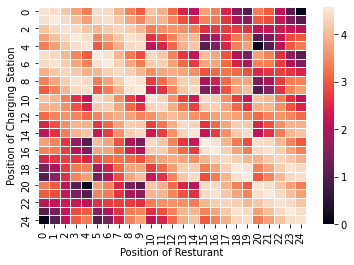

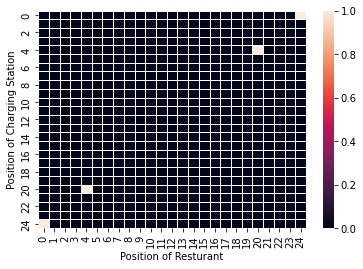

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

grid_size = 5
wind = 0.1
discount = 0.9
horizon = 10
start_state = 15
feature_dim = 2
# p1 = 4
# p2 = 4
theta = 5*np.ones((2,1))

ones_ = np.ones((gw.n_states*gw.n_actions,1))

data = np.zeros((grid_size**2, grid_size**2))

interesting = []

for p1 in range(grid_size**2):
    for p2 in range(grid_size**2):
        
        gw = BlockingGridworld(grid_size,wind,discount,horizon,start_state, feature_dim, p1,p2,theta)

        F = gw.F_matrix()

        v = np.linalg.lstsq(F,ones_, rcond = None)

        data[p1][p2] = np.linalg.norm(F@v[0] - ones_)
        
        A = E@K_eta
        B = F

        # find their intersection
        M = np.hstack((A,-B))

        V = scipy.linalg.null_space(M)
        if V.shape[1] >= 1:
            print(V.shape[1])
#             print("yoyo")
            interesting.append((p1,p2))

print("Done. Generating Plot ...")

ax = sns.heatmap(data, linewidth=0.5)
plt.xlabel("Position of Resturant")
plt.ylabel("Position of Charging Station")
plt.show()

ax = sns.heatmap(data<1e-5, linewidth=0.5)
plt.xlabel("Position of Resturant")
plt.ylabel("Position of Charging Station")
plt.show()


In [ ]:
data.min()

In [16]:
interesting

[(0, 0),
 (0, 24),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (4, 20),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 10),
 (11, 11),
 (12, 12),
 (13, 13),
 (14, 14),
 (15, 15),
 (16, 16),
 (17, 17),
 (18, 18),
 (19, 19),
 (20, 4),
 (20, 20),
 (21, 21),
 (22, 22),
 (23, 23),
 (24, 0),
 (24, 24)]

In [ ]:
U,S,V=np.linalg.svd(Psi)

In [47]:
K  = scipy.linalg.null_space(Psi)
K_eta = K[-gw.n_states:,:]

A = E@K_eta
B = F

# find their intersection
M = np.hstack((A,-B))

V = scipy.linalg.null_space(M)
# assert V.shape[1] == 1

V_p = V[:A.shape[1]]

intersection = A@V_p

intersection.shape


(100, 1)

In [46]:
intersection.min()/intersection.max()

1360.2864732476735

In [29]:
intersection.max()

1.2194934367960773e-15

In [ ]:
state_of_interest = 1
list_ = np.arange(state_of_interest,100,grid_size**2)
F[list_].T

In [ ]:
np.round(K_eta,3)

In [ ]:
A = np.random.rand(10,5)
B = np.random.rand(10,3)

l = scipy.linalg.null_space(np.hstack((scipy.linalg.null_space(A.T), scipy.linalg.null_space(B.T)  )).T)

In [ ]:
l.shape

In [ ]:
M = np.hstack((A,-B))

V = scipy.linalg.null_space(M)
assert V.shape[1] == 1

V_p = V[:A.shape[1]]

intersection = A@V_p